# CodeCLIP Experiment Notebook
Configuration-driven analysis of code generation across different models and labeling schemes.

# Configuration

In [37]:
# Configuration Parameters
# 'model': multi-class (gpt, codellama, llama3.1, human)
# 'target': binary (human, ai)
label_field = 'model'

checkpoint_dir = 'checkpoints/CodeCLIP_unified'
num_epochs = 100
batch_size = 128
embedding_dim = 256
learning_rate = 1e-3
graph_in_dim = 384
seed = 42
skip_training_if_exists = False

# Imports & Environment Setup

In [38]:
import subprocess
import sys
import ast
import os
import random

from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINEConv, global_mean_pool
from torch_geometric.utils import to_dense_batch

from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

# Setup environment
subprocess.run([sys.executable, "-m", "pip", "install", "--upgrade", "pip", "setuptools", "wheel", "-q"], capture_output=True)
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "torch_geometric"], capture_output=True)

for pkg in ["torch-scatter", "torch-sparse", "torch-cluster"]:
    result = subprocess.run([sys.executable, "-m", "pip", "install", "-q", pkg], capture_output=True, text=True)
    if result.returncode != 0:
        pass

print(f"PyTorch: {torch.__version__}")
print(f"PyG: {torch_geometric.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
print("✓ All imports ready")

PyTorch: 2.9.0+cu128
PyG: 2.7.0
Device: cuda
✓ All imports ready


# Data Loading & Sampling

In [39]:
random.seed(seed)
np.random.seed(seed)
plt.style.use('seaborn-v0_8-darkgrid')

dataset = load_dataset("DaniilOr/CoDET-M4")
python_dataset = dataset['train'].filter(lambda x: x['language'] == 'python')
print(f"Loaded {len(python_dataset)} Python samples")

Loaded 185163 Python samples


In [40]:
all_labels = [l for l in python_dataset[label_field] if l is not None]
unique_labels = sorted(list(set(all_labels)))
print(f"Found {len(unique_labels)} labels: {unique_labels}")

selected_indices = []
for label in unique_labels:
    label_indices = [i for i, l in enumerate(python_dataset[label_field]) if l == label]
    count = min(5, len(label_indices))
    features = random.sample(label_indices, count)
    selected_indices.extend(features)
    print(f"  {label}: {count} samples")

random.shuffle(selected_indices)
sample_code = python_dataset.select(selected_indices)
print(f"Total: {len(sample_code)} samples")

Found 6 labels: ['codellama', 'gpt', 'human', 'llama3.1', 'nxcode', 'qwen1.5']
  codellama: 5 samples
  gpt: 5 samples
  human: 5 samples
  llama3.1: 5 samples
  nxcode: 5 samples
  qwen1.5: 5 samples
Total: 30 samples


In [41]:
pd.set_option('display.max_columns', None)
df = pd.DataFrame(sample_code)
df.head()

,code,language,model,split,target,source,features,cleaned_code,__index_level_0__
0,"def set_ghost_file(self, ghost_file):\n ...",python,human,train,human,gh,"{'avgFunctionLength': 1.0, 'avgIdentifierLengt...","def set_ghost_file(self, ghost_file):\n ...",40653
1,from functools import lru_cache\n\ndef maximal...,python,llama3.1,train,ai,lc,"{'avgFunctionLength': 1.0, 'avgIdentifierLengt...",from functools import lru_cache\n\ndef maximal...,47175
2,"class Solution:\r\n def diagonalSort(self, ...",python,nxcode,test,ai,lc,"{'avgFunctionLength': 1.0, 'avgIdentifierLengt...","class Solution:\r\n def diagonalSort(self, ...",14996
3,"numbers = [""5"", ""2"", ""8"", ""1"", ""9""]\nnumbers.s...",python,llama3.1,train,ai,lc,"{'avgFunctionLength': 0.0, 'avgIdentifierLengt...","numbers = [""5"", ""2"", ""8"", ""1"", ""9""]\nnumbers.s...",47636
4,"def find_sink_variables(self):\n """"""\n F...",python,llama3.1,train,ai,gh,"{'avgFunctionLength': 1.0, 'avgIdentifierLengt...",def find_sink_variables(self):\n,35534


# Text to AST

In [42]:
valid_indices = []
sample_asts = []

for idx, example in enumerate(sample_code):
    try:
        tree = ast.parse(example['code'])
        sample_asts.append(tree)
        valid_indices.append(idx)
    except (SyntaxError, Exception):
        pass

if len(valid_indices) < len(sample_code):
    print(f"Filtered out {len(sample_code) - len(valid_indices)} invalid examples")
    sample_code = sample_code.select(valid_indices)

print(f"Valid AST samples: {len(sample_code)}")

Filtered out 1 invalid examples
Valid AST samples: 29


# AST to PyG

In [43]:
def ast_to_pyg_data(code_str, target_label):
    """Convert Python code to PyG Data object via AST."""
    try:
        tree = ast.parse(code_str)
    except SyntaxError:
        return None

    node_list = []
    edge_index = [[], []]
    edge_attr = []

    def visit(node, parent_idx=None, relation=None):
        nonlocal node_list, edge_index, edge_attr
        curr_idx = len(node_list)
        node_type = type(node).__name__
        node_list.append({'type': node_type})
        
        if parent_idx is not None:
            edge_index[0].append(parent_idx)
            edge_index[1].append(curr_idx)
            edge_attr.append(relation if relation else "child")
            
        for field, value in ast.iter_fields(node):
            if isinstance(value, list):
                for item in value:
                    if isinstance(item, ast.AST):
                        visit(item, curr_idx, field)
            elif isinstance(value, ast.AST):
                visit(value, curr_idx, field)

    visit(tree)
    if not node_list:
        return None
    
    return Data(
        edge_index=torch.tensor(edge_index, dtype=torch.long),
        num_nodes=len(node_list),
        node_texts=[n['type'] for n in node_list],
        edge_texts=edge_attr,
        code=code_str,
        y=target_label
    )

pyg_dataset = []
for idx, item in enumerate(sample_code):
    data = ast_to_pyg_data(item['code'], item[label_field])
    if data:
        pyg_dataset.append(data)

print(f"Created {len(pyg_dataset)} PyG graphs")

Created 29 PyG graphs


# Feature Encoding

In [44]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def encode_text_graph(dataset, lm_type="tiny", batch_size=32, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    
    text_models = {
        "tiny": "sentence-transformers/all-MiniLM-L6-v2",
        "e5": "intfloat/e5-base-v2",
    }
    
    model_id = text_models.get(lm_type, text_models["tiny"])
    print(f"Loading model: {model_id}")
    
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_id)
        model = AutoModel.from_pretrained(model_id).to(device)
    except OSError:
        print(f"Model {model_id} not found. Check connection or model name.")
        return dataset
        
    model.eval()

    def get_embeddings(texts):
        if not texts:
            return None
        all_embs = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i : i + batch_size]
            encoded_input = tokenizer(
                batch, padding=True, truncation=True, 
                max_length=128, return_tensors='pt'
            ).to(device)

            with torch.no_grad():
                model_output = model(**encoded_input)
                sample_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
            all_embs.append(sample_embeddings.cpu())
        if all_embs:
            return torch.cat(all_embs, dim=0)
        return None

    print(f"Encoding features for {len(dataset)} graphs...")
    for i, data in enumerate(tqdm(dataset)):
        if hasattr(data, 'node_texts') and data.node_texts:
            data.x = get_embeddings(data.node_texts)
        if hasattr(data, 'edge_texts') and data.edge_texts:
            data.edge_attr = get_embeddings(data.edge_texts)
    return dataset

print("✓ Encoding functions ready")

✓ Encoding functions ready


In [45]:
pyg_dataset = encode_text_graph(pyg_dataset, lm_type="tiny")

if len(pyg_dataset) > 0:
    g = pyg_dataset[0]
    print(f"Node embeddings: {g.x.shape if hasattr(g, 'x') and g.x is not None else 'None'}")
    print(f"Edge embeddings: {g.edge_attr.shape if hasattr(g, 'edge_attr') and g.edge_attr is not None else 'None'}")

Loading model: sentence-transformers/all-MiniLM-L6-v2


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Encoding features for 29 graphs...


100%|██████████| 29/29 [00:01<00:00, 19.66it/s]

Node embeddings: torch.Size([63, 384])
Edge embeddings: torch.Size([62, 384])


# CodeCLIP Module

In [46]:
class GraphEncoder(nn.Module):
    def __init__(self, in_dim=384, hidden_dim=256, out_dim=256, num_layers=2):
        super(GraphEncoder, self).__init__()
        self.node_proj = nn.Linear(in_dim, hidden_dim)
        self.edge_proj = nn.Linear(in_dim, hidden_dim)
        self.convs = nn.ModuleList()
        
        for _ in range(num_layers):
            mlp = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim), 
                nn.ReLU(), 
                nn.Linear(hidden_dim, hidden_dim)
            )
            self.convs.append(GINEConv(mlp, train_eps=True))
            
        self.out_proj = nn.Linear(hidden_dim, out_dim)
        self.alpha = nn.Parameter(torch.tensor(1.0))

    def forward(self, x, edge_index, edge_attr, batch=None):
        if batch is None:
            batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)

        h = self.node_proj(x)
        e = self.edge_proj(edge_attr)
        
        for conv in self.convs:
            x = conv(h, edge_index, e) + h
            h = torch.relu(x)
            
        h_mean = global_mean_pool(h, batch)
        h_dense, _ = to_dense_batch(h, batch)
        h_root = h_dense[:, 0, :] 
        out = h_mean + self.alpha * h_root
        
        return self.out_proj(out)


class TextEncoder(nn.Module):
    def __init__(self, vocab_size=30522, embed_dim=256, num_heads=4, num_layers=2, max_len=512):
        super(TextEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = nn.Parameter(torch.randn(1, max_len, embed_dim))
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
    def forward(self, x):
        x_emb = self.embedding(x)
        seq_len = x.shape[1]
        x_emb = x_emb + self.pos_encoder[:, :seq_len, :]
        x_out = self.transformer(x_emb)
        return x_out.mean(dim=1)


class Pretrain(nn.Module):
    def __init__(self, graph_in_dim=384, text_vocab_size=30522, embed_dim=256):
        super(Pretrain, self).__init__()
        self.graph_encoder = GraphEncoder(in_dim=graph_in_dim, hidden_dim=embed_dim, out_dim=embed_dim)
        self.text_encoder = TextEncoder(vocab_size=text_vocab_size, embed_dim=embed_dim)
        self.logit_scale = nn.Parameter(torch.ones([]) * 0.07)
        
    def forward(self, graph_batch, text_input):
        graph_features = self.graph_encoder(graph_batch.x, graph_batch.edge_index, graph_batch.edge_attr, graph_batch.batch)
        text_features = self.text_encoder(text_input)
        
        graph_features = graph_features / graph_features.norm(dim=1, keepdim=True)
        text_features = text_features / text_features.norm(dim=1, keepdim=True)
        
        logit_scale = self.logit_scale.exp()
        logits_per_graph = logit_scale * graph_features @ text_features.t()
        logits_per_text = logits_per_graph.t()
        
        return logits_per_graph, logits_per_text
        
    def loss(self, logits_per_graph, logits_per_text):
        batch_size = logits_per_graph.shape[0]
        labels = torch.arange(batch_size, device=logits_per_graph.device)
        loss_graph = nn.functional.cross_entropy(logits_per_graph, labels)
        loss_text = nn.functional.cross_entropy(logits_per_text, labels)
        return (loss_graph + loss_text) / 2


class Downstream(nn.Module):
    def __init__(self, pretrained_model, embed_dim=256, num_classes=2, hidden_dim=128):
        super(Downstream, self).__init__()
        self.graph_encoder = pretrained_model.graph_encoder
        for param in self.graph_encoder.parameters():
            param.requires_grad = False
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, graph_batch):
        features = self.graph_encoder(graph_batch.x, graph_batch.edge_index, graph_batch.edge_attr, graph_batch.batch)
        return self.classifier(features)

print("✓ CodeCLIP models loaded")

✓ CodeCLIP models loaded


In [47]:
os.makedirs(checkpoint_dir, exist_ok=True)
loader = DataLoader(pyg_dataset, batch_size=batch_size, shuffle=True)

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
vocab_size = tokenizer.vocab_size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Pretrain(graph_in_dim=graph_in_dim, text_vocab_size=vocab_size, embed_dim=embedding_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint.pt')

if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    print(f"Loaded checkpoint from {checkpoint_path}")
    if skip_training_if_exists:
        print("Skipping training")

if not (os.path.exists(checkpoint_path) and skip_training_if_exists):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, data in enumerate(loader):
            data = data.to(device)
            text_inputs = tokenizer(
                data.code, padding=True, truncation=True, 
                max_length=512, return_tensors='pt'
            ).input_ids.to(device)
            
            optimizer.zero_grad()
            logits_graph, logits_text = model(data, text_inputs)
            loss = model.loss(logits_graph, logits_text)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        avg_loss = total_loss / len(loader)
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
        torch.save(model.state_dict(), checkpoint_path)
    
    print("Training complete")

Loaded checkpoint from checkpoints/CodeCLIP_unified/checkpoint.pt
Epoch 1/100, Loss: 2.4047
Epoch 10/100, Loss: 2.6743
Epoch 20/100, Loss: 2.5305
Epoch 30/100, Loss: 2.4864
Epoch 40/100, Loss: 2.4600
Epoch 50/100, Loss: 2.4259
Epoch 60/100, Loss: 2.3704
Epoch 70/100, Loss: 2.3550
Epoch 80/100, Loss: 2.3367
Epoch 90/100, Loss: 2.3208
Epoch 100/100, Loss: 2.2926
Training complete


# Extract Graph Embeddings

In [48]:
model.eval()
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

graph_embeddings = []
with torch.no_grad():
    for batch_idx, data in enumerate(loader):
        data = data.to(device)
        features = model.graph_encoder(data.x, data.edge_index, data.edge_attr, data.batch)
        features = features / features.norm(dim=1, keepdim=True)
        graph_embeddings.append(features.cpu())

all_graph_embeddings = torch.cat(graph_embeddings, dim=0)
print(f"Extracted embeddings: {all_graph_embeddings.shape}")

Extracted embeddings: torch.Size([29, 256])


# Visualization Suite

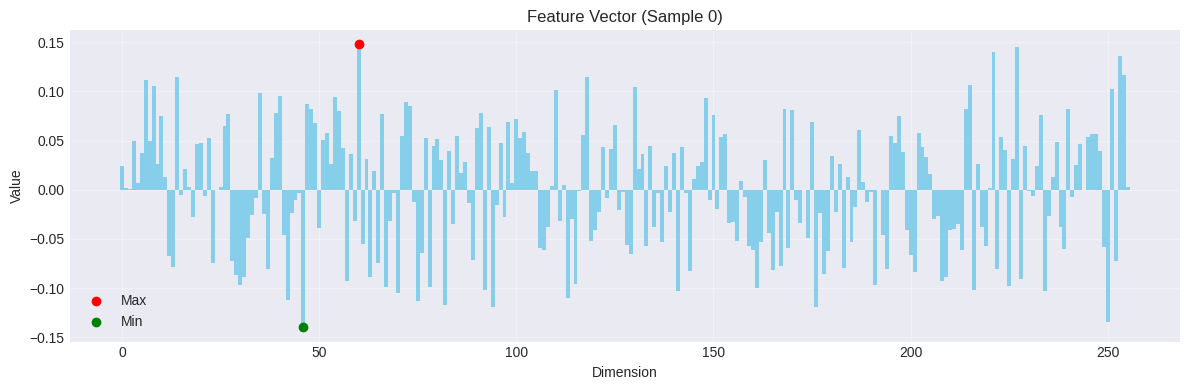

In [49]:
embedding_vector = all_graph_embeddings[0, :].numpy()

plt.figure(figsize=(12, 4))
plt.bar(range(len(embedding_vector)), embedding_vector, color='skyblue', width=1.0)
plt.title('Feature Vector (Sample 0)')
plt.xlabel('Dimension')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)

max_idx = np.argmax(embedding_vector)
min_idx = np.argmin(embedding_vector)
plt.scatter([max_idx], [embedding_vector[max_idx]], color='red', label='Max', zorder=5)
plt.scatter([min_idx], [embedding_vector[min_idx]], color='green', label='Min', zorder=5)
plt.legend()
plt.tight_layout()
plt.show()

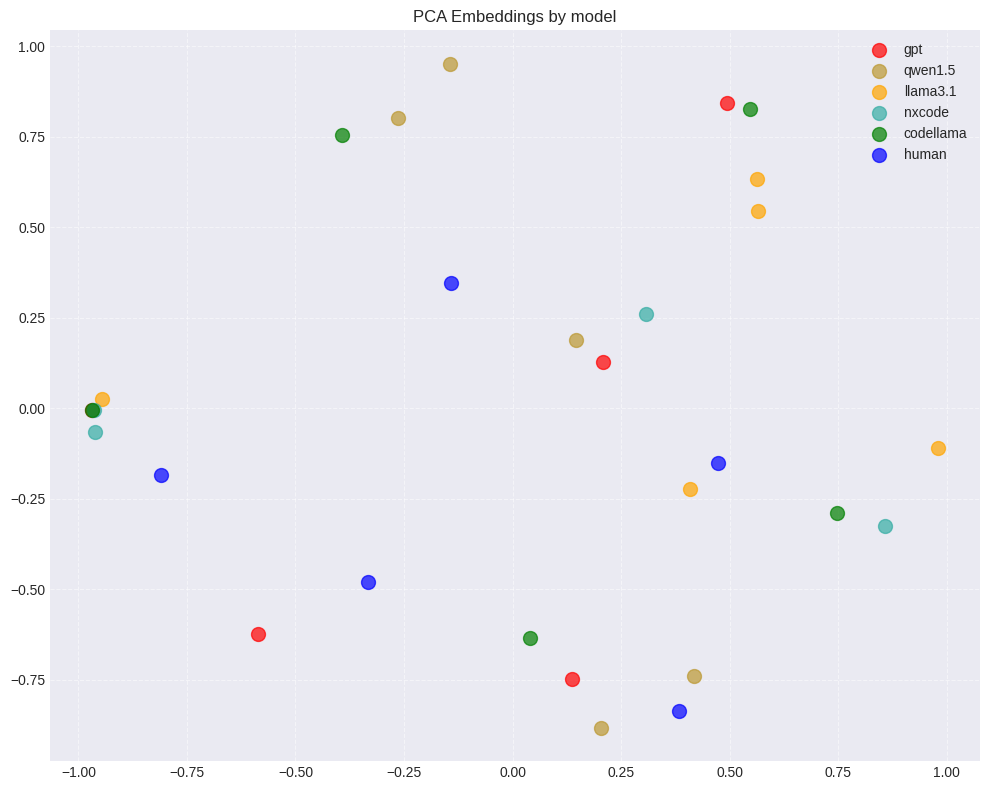

In [50]:
embeddings = all_graph_embeddings.detach().cpu().numpy()
labels = [data.y for data in pyg_dataset]

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
label_set = list(set(labels))

color_map = {
    'human': 'blue', 'gpt': 'red', 'gpt4o': 'darkred',
    'llama3.1': 'orange', 'codellama': 'green', 'ai': 'red'
}
fallback_colors = sns.color_palette("husl", len(label_set))

for i, label in enumerate(label_set):
    indices = [j for j, l in enumerate(labels) if l == label]
    if indices:
        color = color_map.get(label, fallback_colors[i])
        plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1],
                   c=[color], label=label, alpha=0.7, s=100)

plt.title(f'PCA Embeddings by {label_field}')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

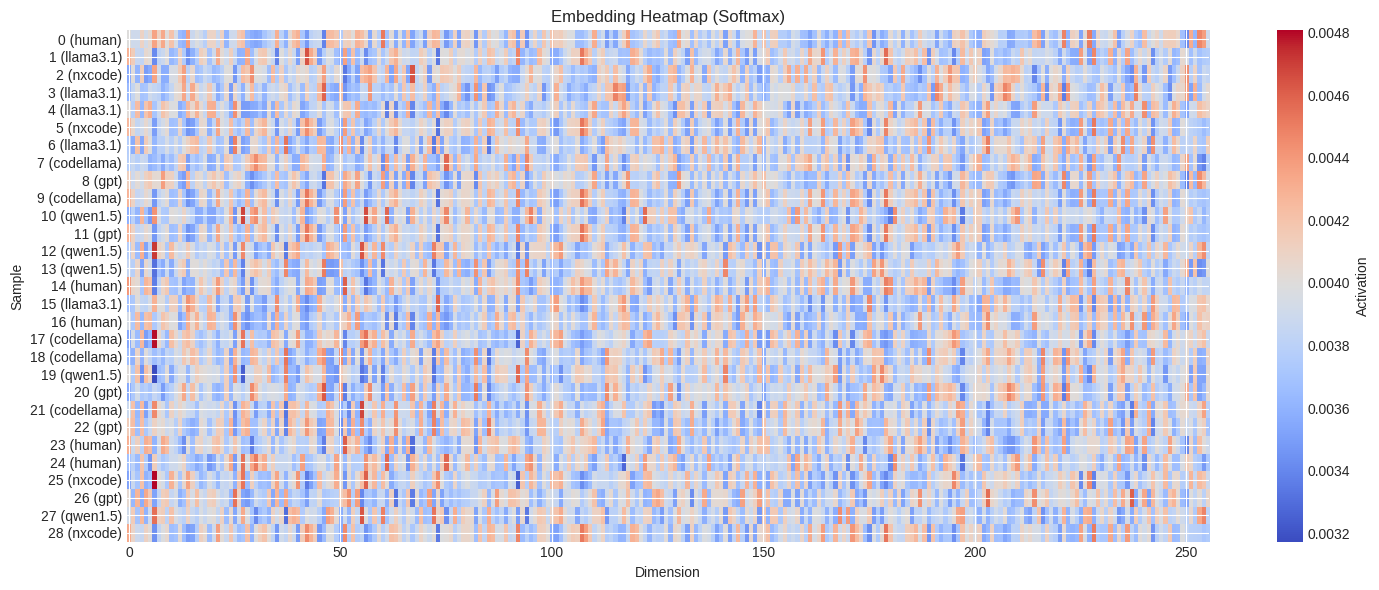

In [51]:
embeddings = all_graph_embeddings.detach().cpu().numpy()
embeddings_exp = np.exp(embeddings - np.max(embeddings, axis=1, keepdims=True))
embeddings_exp = embeddings_exp / np.sum(embeddings_exp, axis=1, keepdims=True)

plt.figure(figsize=(15, 6))
img = plt.imshow(embeddings_exp, cmap='coolwarm', aspect='auto', interpolation='nearest')
plt.colorbar(img, label='Activation')
plt.title('Embedding Heatmap (Softmax)')
plt.xlabel('Dimension')
plt.ylabel('Sample')
labels_viz = [data.y for data in pyg_dataset]
plt.yticks(range(len(embeddings)), labels=[f"{i} ({l})" for i, l in enumerate(labels_viz)])
plt.tight_layout()
plt.show()

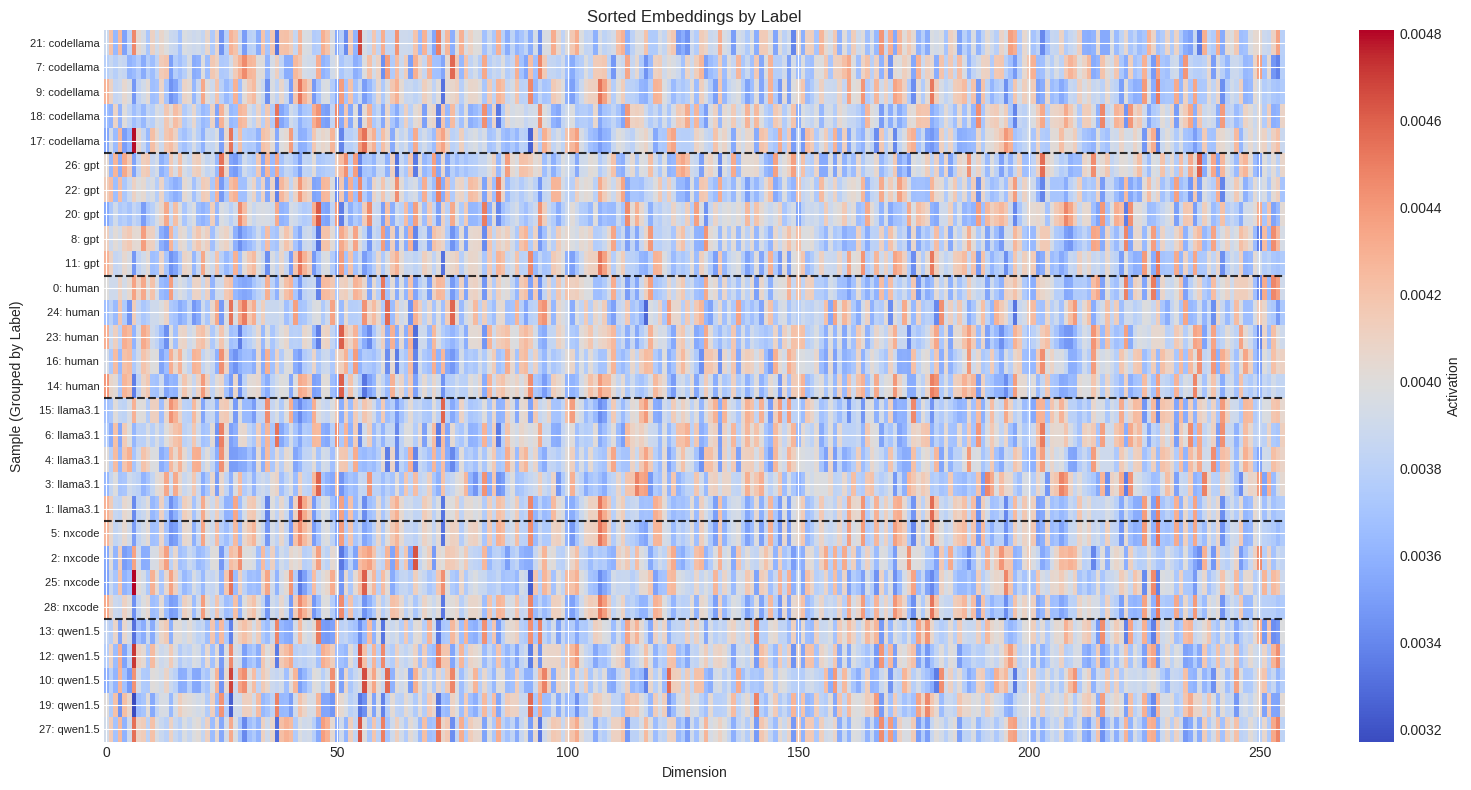

In [52]:
embeddings_np = all_graph_embeddings.detach().cpu().numpy()
labels_list = [data.y for data in pyg_dataset]

sorted_indices = np.argsort(labels_list)
sorted_embeddings = embeddings_np[sorted_indices]
sorted_labels = np.array(labels_list)[sorted_indices]

exp_vals = np.exp(sorted_embeddings - np.max(sorted_embeddings, axis=1, keepdims=True))
embeddings_processed = exp_vals / np.sum(exp_vals, axis=1, keepdims=True)

plt.figure(figsize=(16, 8))
img = plt.imshow(embeddings_processed, cmap='coolwarm', aspect='auto', interpolation='nearest')

for i in range(1, len(sorted_labels)):
    if sorted_labels[i] != sorted_labels[i-1]:
        plt.axhline(y=i-0.5, color='black', linestyle='--', linewidth=1.5, alpha=0.8)

plt.colorbar(img, label='Activation')
plt.title('Sorted Embeddings by Label')
plt.xlabel('Dimension')
plt.ylabel('Sample (Grouped by Label)')
plt.yticks(range(len(sorted_labels)), [f"{i}: {l}" for i, l in zip(sorted_indices, sorted_labels)], fontsize=8)
plt.tight_layout()
plt.show()

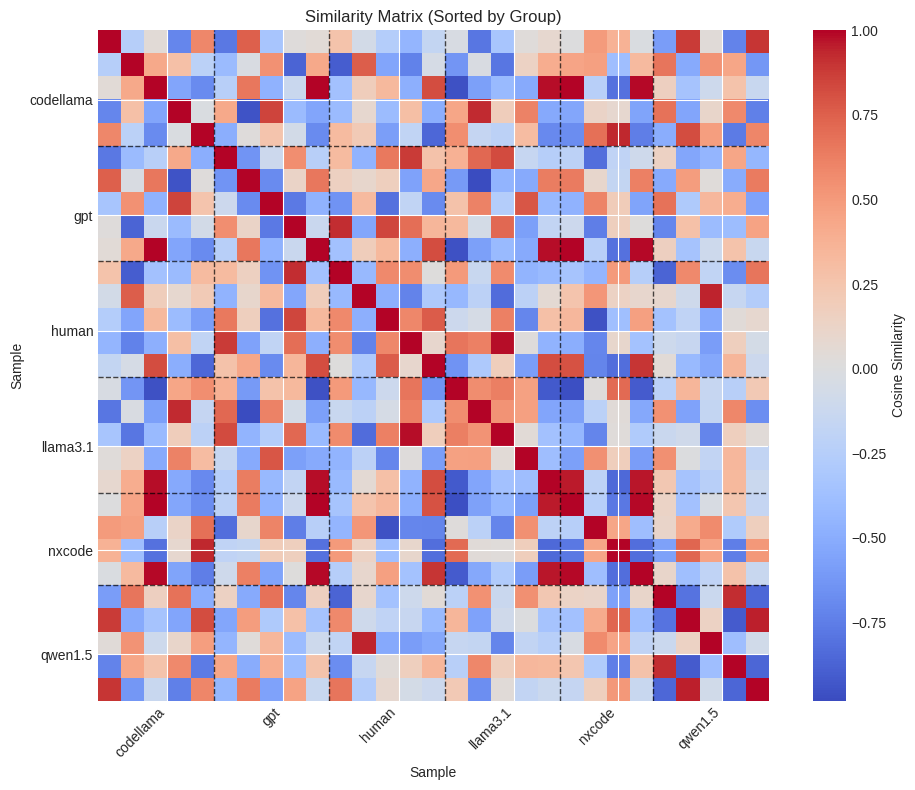

In [53]:
embeddings_np = all_graph_embeddings.detach().cpu().numpy()
labels_list = [data.y for data in pyg_dataset]

sorted_indices = np.argsort(labels_list)
sorted_embeddings = embeddings_np[sorted_indices]
sorted_labels = np.array(labels_list)[sorted_indices]

norms = np.linalg.norm(sorted_embeddings, axis=1, keepdims=True)
normalized_embeddings = sorted_embeddings / (norms + 1e-8)
similarity_matrix = np.dot(normalized_embeddings, normalized_embeddings.T)

plt.figure(figsize=(10, 8))
img = plt.imshow(similarity_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(img, label='Cosine Similarity')

transitions = [i for i in range(1, len(sorted_labels)) if sorted_labels[i] != sorted_labels[i-1]]
for t in transitions:
    plt.axhline(y=t-0.5, color='black', linestyle='--', linewidth=1, alpha=0.7)
    plt.axvline(x=t-0.5, color='black', linestyle='--', linewidth=1, alpha=0.7)

group_starts = [0] + transitions + [len(sorted_labels)]
tick_locs = [(group_starts[i] + group_starts[i+1]) / 2 for i in range(len(group_starts)-1)]
group_names = [sorted_labels[group_starts[i]] for i in range(len(group_starts)-1)]

plt.title('Similarity Matrix (Sorted by Group)')
plt.xlabel('Sample')
plt.ylabel('Sample')
plt.xticks(tick_locs, group_names, rotation=45, ha='right')
plt.yticks(tick_locs, group_names)
plt.tight_layout()
plt.show()

# Experiment Summary

In [57]:
unique_labels_final = sorted(list(set([data.y for data in pyg_dataset])))
label_counts = {label: sum(1 for d in pyg_dataset if d.y == label) for label in unique_labels_final}
label_info = ", ".join([f"{label} ({count})" for label, count in label_counts.items()])

summary = f"""
Configuration:
  Label Field: {label_field}  |  Epochs: {num_epochs}  |  Batch: {batch_size}  |  Embedding Dim: {embedding_dim}

Data Pipeline:
  Original Samples: {len(sample_code)}  →  Valid Graphs: {len(pyg_dataset)}
  Labels: {label_info}

Embeddings:
  Shape: {all_graph_embeddings.shape[0]} samples × {all_graph_embeddings.shape[1]} dimensions
"""
print(summary)


Configuration:
  Label Field: model  |  Epochs: 100  |  Batch: 128  |  Embedding Dim: 256

Data Pipeline:
  Original Samples: 29  →  Valid Graphs: 29
  Labels: codellama (5), gpt (5), human (5), llama3.1 (5), nxcode (4), qwen1.5 (5)

Embeddings:
  Shape: 29 samples × 256 dimensions

